## Image classification with deep learning methods.

--- Description ---

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [1]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
# Install and import the MedMNIST package and datasets.

#!pip install medmnist
import medmnist
from medmnist import info

In [3]:
from medmnist import OrganAMNIST

train_set = OrganAMNIST(split="train", download=True)
val_set = OrganAMNIST(split="val", download=True)
test_set = OrganAMNIST(split="test", download=True)

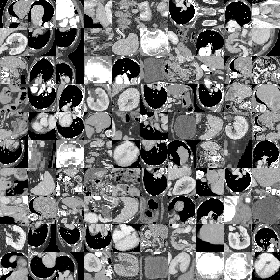

In [4]:
train_set.montage(length=10)

In [5]:
image, label = train_set[0]
print("Tamaño de la imagen:", np.array(image).shape)

Tamaño de la imagen: (28, 28)


In [6]:
from medmnist import INFO, Evaluator

data_flag = 'organamnist'

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

im_size = 28
in_channels = 784
num_classes = 11

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

download = False

# Load and preprocess data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=2 * BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=2 * BATCH_SIZE, shuffle=False)


In [7]:
# Define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, im_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * (im_size // 2) * (im_size // 2), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes, im_size=im_size)

# Para optimizar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
# Training loop with loss monitoring
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

  0%|          | 0/271 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

Accuracy: 87.19%
AUC: 0.9243


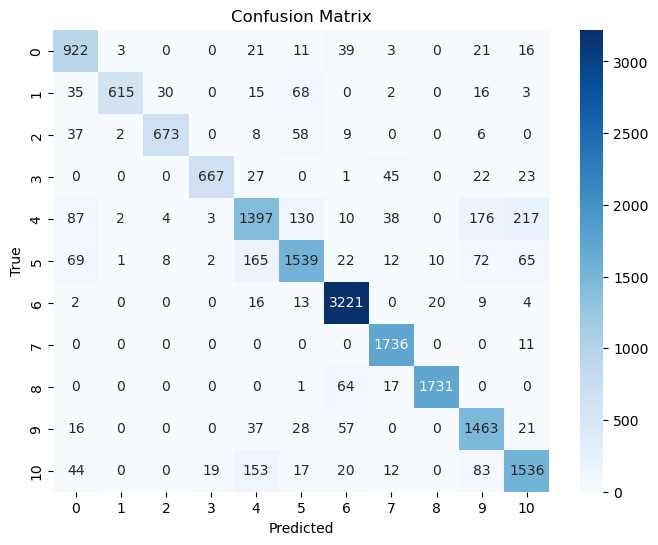

In [107]:
# Evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Medidas
accuracy = 100 * correct / total
auc = roc_auc_score(np.eye(n_classes)[all_targets], np.eye(n_classes)[all_preds], multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}%")
print(f"AUC: {auc:.4f}")


# Matriz de confusión
conf_matrix = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

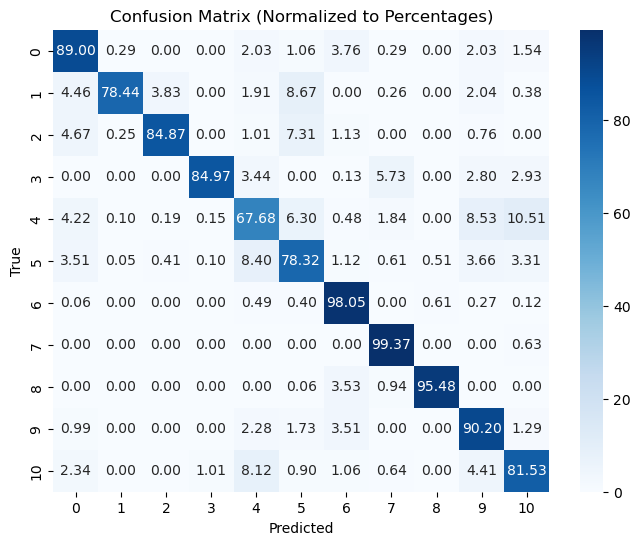

In [108]:
# Matriz de confusión por porcentajes
conf_matrix = confusion_matrix(all_targets, all_preds)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title('Confusion Matrix (Normalized to Percentages)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()